# Read data

In [227]:
import numpy as np
import pandas as pd

# import seaborn as sns
from matplotlib import pyplot as plt

In [228]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

y_train = pd.read_csv('y_train.csv')

y_test = pd.read_csv('sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [229]:
y_train

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0
...,...,...
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4


## Представление целевой переменной

### Kaggle-удобный вид

### Исходный вид

In [230]:
y_train_svod=y_train.copy()
y_train_svod[['sample_id', 'timestep']] = y_train_svod['sample-timestep'].str.split('-', n=1, expand=True).astype(int)
y_train_svod = y_train_svod.pivot(index='sample_id', columns='timestep', values='class')
y_train_svod_index = y_train_svod.index
y_train_svod = y_train_svod.sort_index() # на всякий случай
y_train_svod= y_train_svod.values

print(y_train_svod.shape)


(323, 100)


## Объяснение данных

### Train

In [232]:
X_train.shape, y_train_svod.shape

((323, 40, 100), (323, 100))

`y_train.csv` содержит следующие классы: 
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

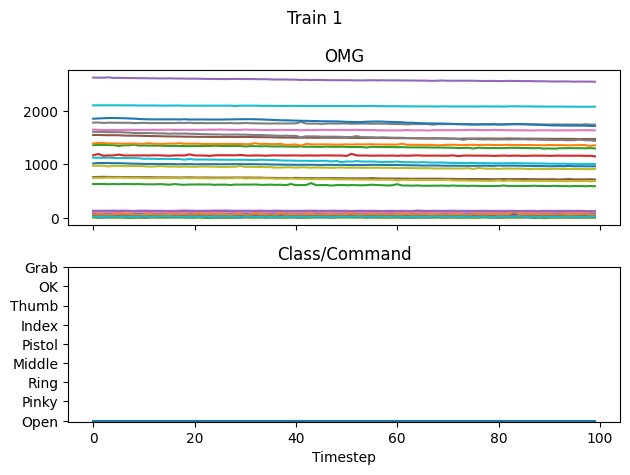

In [233]:
i = 1

fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train_svod[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

In [234]:
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in pd.DataFrame(y_train_svod.T).columns:
    # создаём кортеж (имя столбца, число уникальных значений)
    item = (col, pd.DataFrame(y_train_svod.T)[col].nunique(),pd.DataFrame(y_train_svod.T)[col].dtypes,pd.DataFrame(y_train_svod.T)[col].value_counts()[0]) 
    unique_list.append(item)
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type','value']
).sort_values(by='Num_Unique',  ignore_index=True)
# выводим её на экран
display(unique_counts)


,Column_Name,Num_Unique,Type,value
0,0,1,int64,100
1,108,1,int64,100
2,109,1,int64,100
3,55,1,int64,100
4,144,1,int64,100
...,...,...,...,...
318,111,2,int64,50
319,110,2,int64,50
320,107,2,int64,50
321,116,2,int64,50


Т.к. мы видим, что количество уникальных значений в каждом примере всего 2, то в дальнейшем будем учитывать значения большенства.

### Test

Как видно из визуализации, для теста нет целевой переменной.

Это и есть задача хакатона - предсказать, **какая команда была выполнена пользователем и в какое время**.

# Baseline

In [235]:
data=pd.concat([pd.DataFrame(X_train[0].T), pd.DataFrame(y_train_svod[0],columns=['class'])],axis=1)
for num in range(1,len(X_train)):
    mask=pd.concat([pd.DataFrame(X_train[num].T), pd.DataFrame(y_train_svod[num],columns=['class'])],axis=1)
    data=pd.concat([data,mask],axis=0)  


In [236]:
data_nd=data.drop_duplicates()
data_nd.shape

(32158, 41)

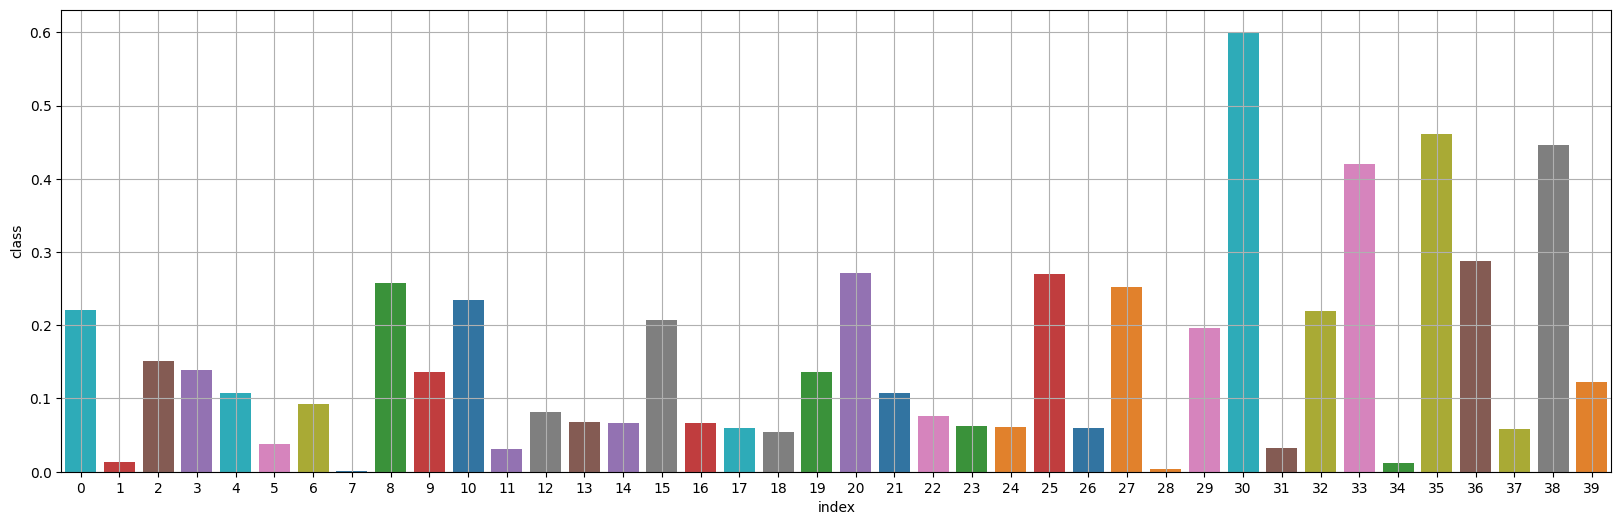

In [237]:
import seaborn as sns
corr_data=data_nd.corr()['class'].abs().sort_values().drop(['class'],axis=0).reset_index()
fig,ax=plt.subplots(figsize=(20,6))
sns.barplot(corr_data,x='index',y='class',ax=ax,hue='class',legend=False,palette='tab10')
ax.grid();

Разделим наши данные на X датасет  и целевой признак y

In [238]:
X=data_nd.drop(['class'],axis=1)
y=data_nd['class']

Рассмотрим наши статистические данные.

In [239]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,...,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000,32158.000000
mean,1079.864544,10.249487,1282.733130,28.558524,23.033087,1572.394770,66.090086,6.692643,975.894832,11.721718,...,1447.906586,69.884228,14.279557,1151.845109,116.740469,24.814385,1741.439206,25.750855,522.127122,23.771192
std,298.077968,6.505825,437.560164,15.739678,7.909427,497.151702,29.853625,4.704801,247.579014,4.357856,...,534.872996,8.055105,5.162583,61.025427,17.740785,4.118110,135.923700,5.678264,165.638618,4.022244
min,538.000000,0.000000,492.000000,0.000000,0.000000,662.000000,15.000000,0.000000,518.000000,0.000000,...,870.000000,3.000000,0.000000,1014.000000,66.000000,3.000000,1362.000000,0.000000,249.000000,0.000000
25%,834.000000,6.000000,993.000000,18.000000,17.000000,1173.000000,41.000000,4.000000,770.000000,9.000000,...,1038.250000,65.000000,11.000000,1103.000000,105.000000,22.000000,1638.000000,23.000000,384.000000,22.000000
50%,1019.000000,10.000000,1230.000000,26.000000,22.000000,1542.000000,53.000000,6.000000,970.500000,11.000000,...,1273.000000,70.000000,14.000000,1140.000000,118.000000,24.000000,1735.000000,26.000000,465.000000,23.000000
75%,1297.000000,14.000000,1460.000000,35.000000,28.000000,1924.000000,91.000000,9.000000,1161.000000,14.000000,...,1749.000000,74.000000,17.000000,1197.000000,130.000000,27.000000,1856.000000,28.000000,629.000000,25.000000
max,2098.000000,72.000000,2715.000000,178.000000,66.000000,3109.000000,160.000000,56.000000,1597.000000,34.000000,...,3099.000000,138.000000,59.000000,1350.000000,171.000000,50.000000,2105.000000,81.000000,965.000000,46.000000


наличие пропусков

In [536]:
X.isnull().sum().sum()

np.int64(0)

Видим, что в каждом столбце максимальные и минимальные значения сильно разняться

In [240]:
from sklearn.model_selection import train_test_split

X_train_0,X_test_0,y_train_0,y_test_0=train_test_split(X,y,random_state=42,stratify=y,test_size=0.2)

## Логистическая регрессия  

In [241]:
from sklearn.linear_model import LogisticRegression
basemodel=LogisticRegression(random_state=42,max_iter=1000,n_jobs=-1,class_weight='balanced',solver='saga',penalty='l1')
basemodel.fit(X_train_0,y_train_0)

/home/roman/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   penalty='l1', random_state=42, solver='saga')

In [242]:
from sklearn import metrics
predict_train_0 = basemodel.predict(X_train_0)
predict_test_0 = basemodel.predict(X_test_0)


print(metrics.classification_report(y_train_0,predict_train_0))

print(metrics.classification_report(y_test_0,predict_test_0))

              precision    recall  f1-score   support

           0       0.87      0.45      0.59     14327
           1       0.46      0.85      0.60      1432
           2       0.61      0.84      0.71      1429
           3       0.55      0.91      0.68      1435
           4       0.48      0.91      0.63      1390
           5       0.55      0.79      0.65      1424
           6       0.49      0.85      0.62      1433
           7       0.54      0.87      0.67      1427
           8       0.66      0.86      0.75      1429

    accuracy                           0.63     25726
   macro avg       0.58      0.82      0.66     25726
weighted avg       0.72      0.63      0.62     25726

              precision    recall  f1-score   support

           0       0.86      0.45      0.59      3582
           1       0.46      0.88      0.61       358
           2       0.60      0.84      0.70       358
           3       0.55      0.91      0.68       359
           4       0.49 

Для первой модели показатели не совсем высокие, посмотрим как она предсказывает.

Проверим на примере, как происходит предсказание данной модели и сравним с нашими данными, которые размечены.

In [243]:
y_train_svod_1=y_train.copy()
y_train_svod_1[['sample_id', 'timestep']] = y_train_svod_1['sample-timestep'].str.split('-', n=1, expand=True).astype(int)
y_train_svod_1['class_predict_1']=basemodel.predict(data.drop(['class'],axis=1))
y_train_svod_1

,sample-timestep,class,sample_id,timestep,class_predict_1
0,0-0,0,0,0,5
1,0-1,0,0,1,5
2,0-2,0,0,2,5
3,0-3,0,0,3,5
4,0-4,0,0,4,5
...,...,...,...,...,...
32295,322-95,4,322,95,4
32296,322-96,4,322,96,4
32297,322-97,4,322,97,4
32298,322-98,4,322,98,4


Сделаем сводную таблицу для дальнейшей визуализации.

In [244]:
mask_predict_1 = y_train_svod_1.pivot(index='sample_id', columns='timestep', values='class_predict_1')
mask_predict_1_index = mask_predict_1.index
mask_predict_1 = mask_predict_1.sort_index() # на всякий случай
mask_predict_1 = mask_predict_1.values

print(mask_predict_1.shape)

(323, 100)


Для сравнения еще раз посмотрим на график распределения признаков и результат команды на размеченных данных

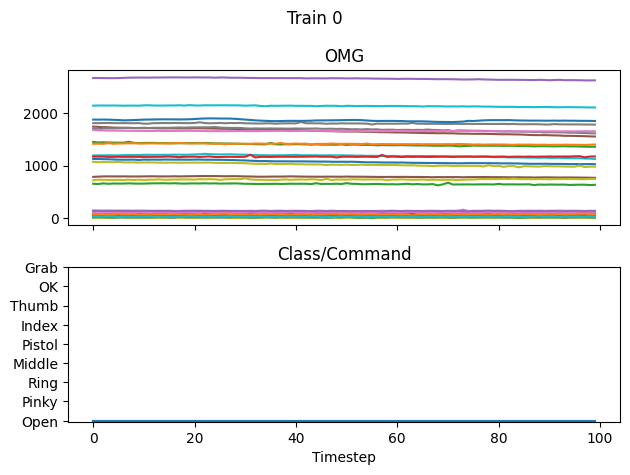

In [245]:
i=0
fig, axx = plt.subplots(2,1,sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train_svod[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()



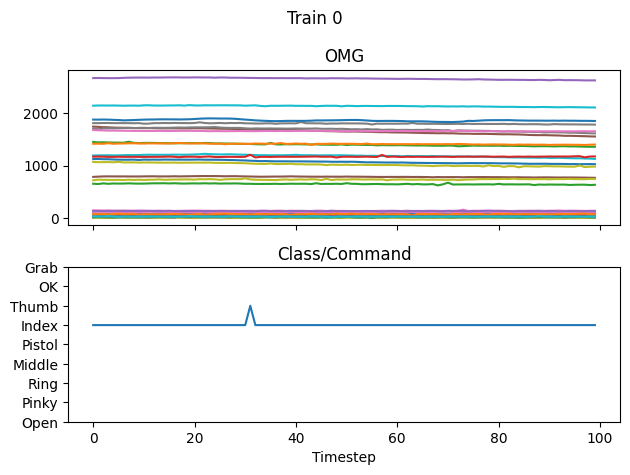

In [246]:

fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(mask_predict_1[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

Наша модель получилась недообученной, т.к. не совсем то, что нам нужно.

## Случайный лес

In [247]:
from sklearn.ensemble import RandomForestClassifier
model_RT=RandomForestClassifier(max_depth=9,
                                min_samples_leaf=5,
                                n_estimators=800,
                                random_state=42,
                                class_weight='balanced',
                                criterion='entropy')
model_RT.fit(X_train_0,y_train_0)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_leaf=5, n_estimators=800,
                       random_state=42)

In [248]:

predict_train_RT_0 = model_RT.predict(X_train_0)
predict_test_RT_0 = model_RT.predict(X_test_0)


print(metrics.classification_report(y_train_0,predict_train_RT_0))

print(metrics.classification_report(y_test_0,predict_test_RT_0))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87     14327
           1       0.66      0.97      0.78      1432
           2       0.81      0.95      0.88      1429
           3       0.82      0.96      0.88      1435
           4       0.78      0.99      0.87      1390
           5       0.82      0.92      0.87      1424
           6       0.79      0.95      0.86      1433
           7       0.80      0.95      0.87      1427
           8       0.85      0.94      0.89      1429

    accuracy                           0.87     25726
   macro avg       0.81      0.94      0.86     25726
weighted avg       0.88      0.87      0.87     25726

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      3582
           1       0.66      0.96      0.78       358
           2       0.81      0.92      0.86       358
           3       0.79      0.91      0.84       359
           4       0.78 

In [249]:
y_train_svod_1['class_predict_2']=model_RT.predict(data.drop(['class'],axis=1))
y_train_svod_1

,sample-timestep,class,sample_id,timestep,class_predict_1,class_predict_2
0,0-0,0,0,0,5,0
1,0-1,0,0,1,5,0
2,0-2,0,0,2,5,0
3,0-3,0,0,3,5,0
4,0-4,0,0,4,5,0
...,...,...,...,...,...,...
32295,322-95,4,322,95,4,4
32296,322-96,4,322,96,4,4
32297,322-97,4,322,97,4,4
32298,322-98,4,322,98,4,4


In [250]:
mask_predict_2 = y_train_svod_1.pivot(index='sample_id', columns='timestep', values='class_predict_2')
mask_predict_2_index = mask_predict_2.index
mask_predict_2 = mask_predict_2.sort_index() # на всякий случай
mask_predict_2 = mask_predict_2.values

print(mask_predict_2.shape)
pd.DataFrame(mask_predict_2)

(323, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,6,...,6,6,6,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,0,0,0,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8
319,8,8,8,8,8,8,8,8,8,8,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
321,7,7,7,7,7,7,7,7,7,7,...,0,4,4,4,4,4,4,4,4,4


Теперь проверим нашу модель Случайный лес  так же на размеченных данных. Для визуализации и понимания, что делать дальше.

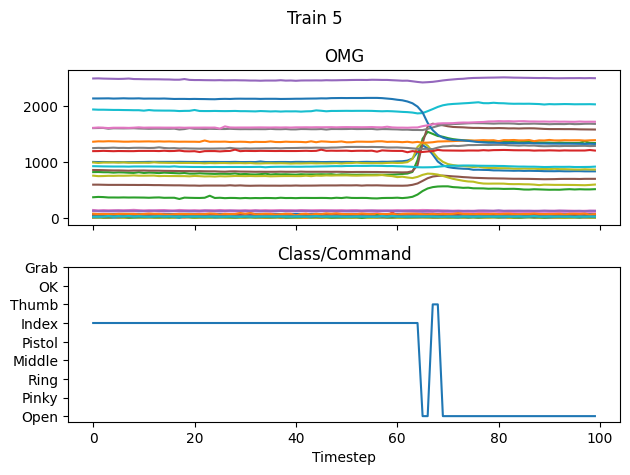

In [251]:
i=5
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(mask_predict_2[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

Есть изъяны, то с этой моделью будет лучше нам работать в дальнейшем. Она показывает картину, приближенную к размеченым данным

Рассмотрим корреляцию наших признаков

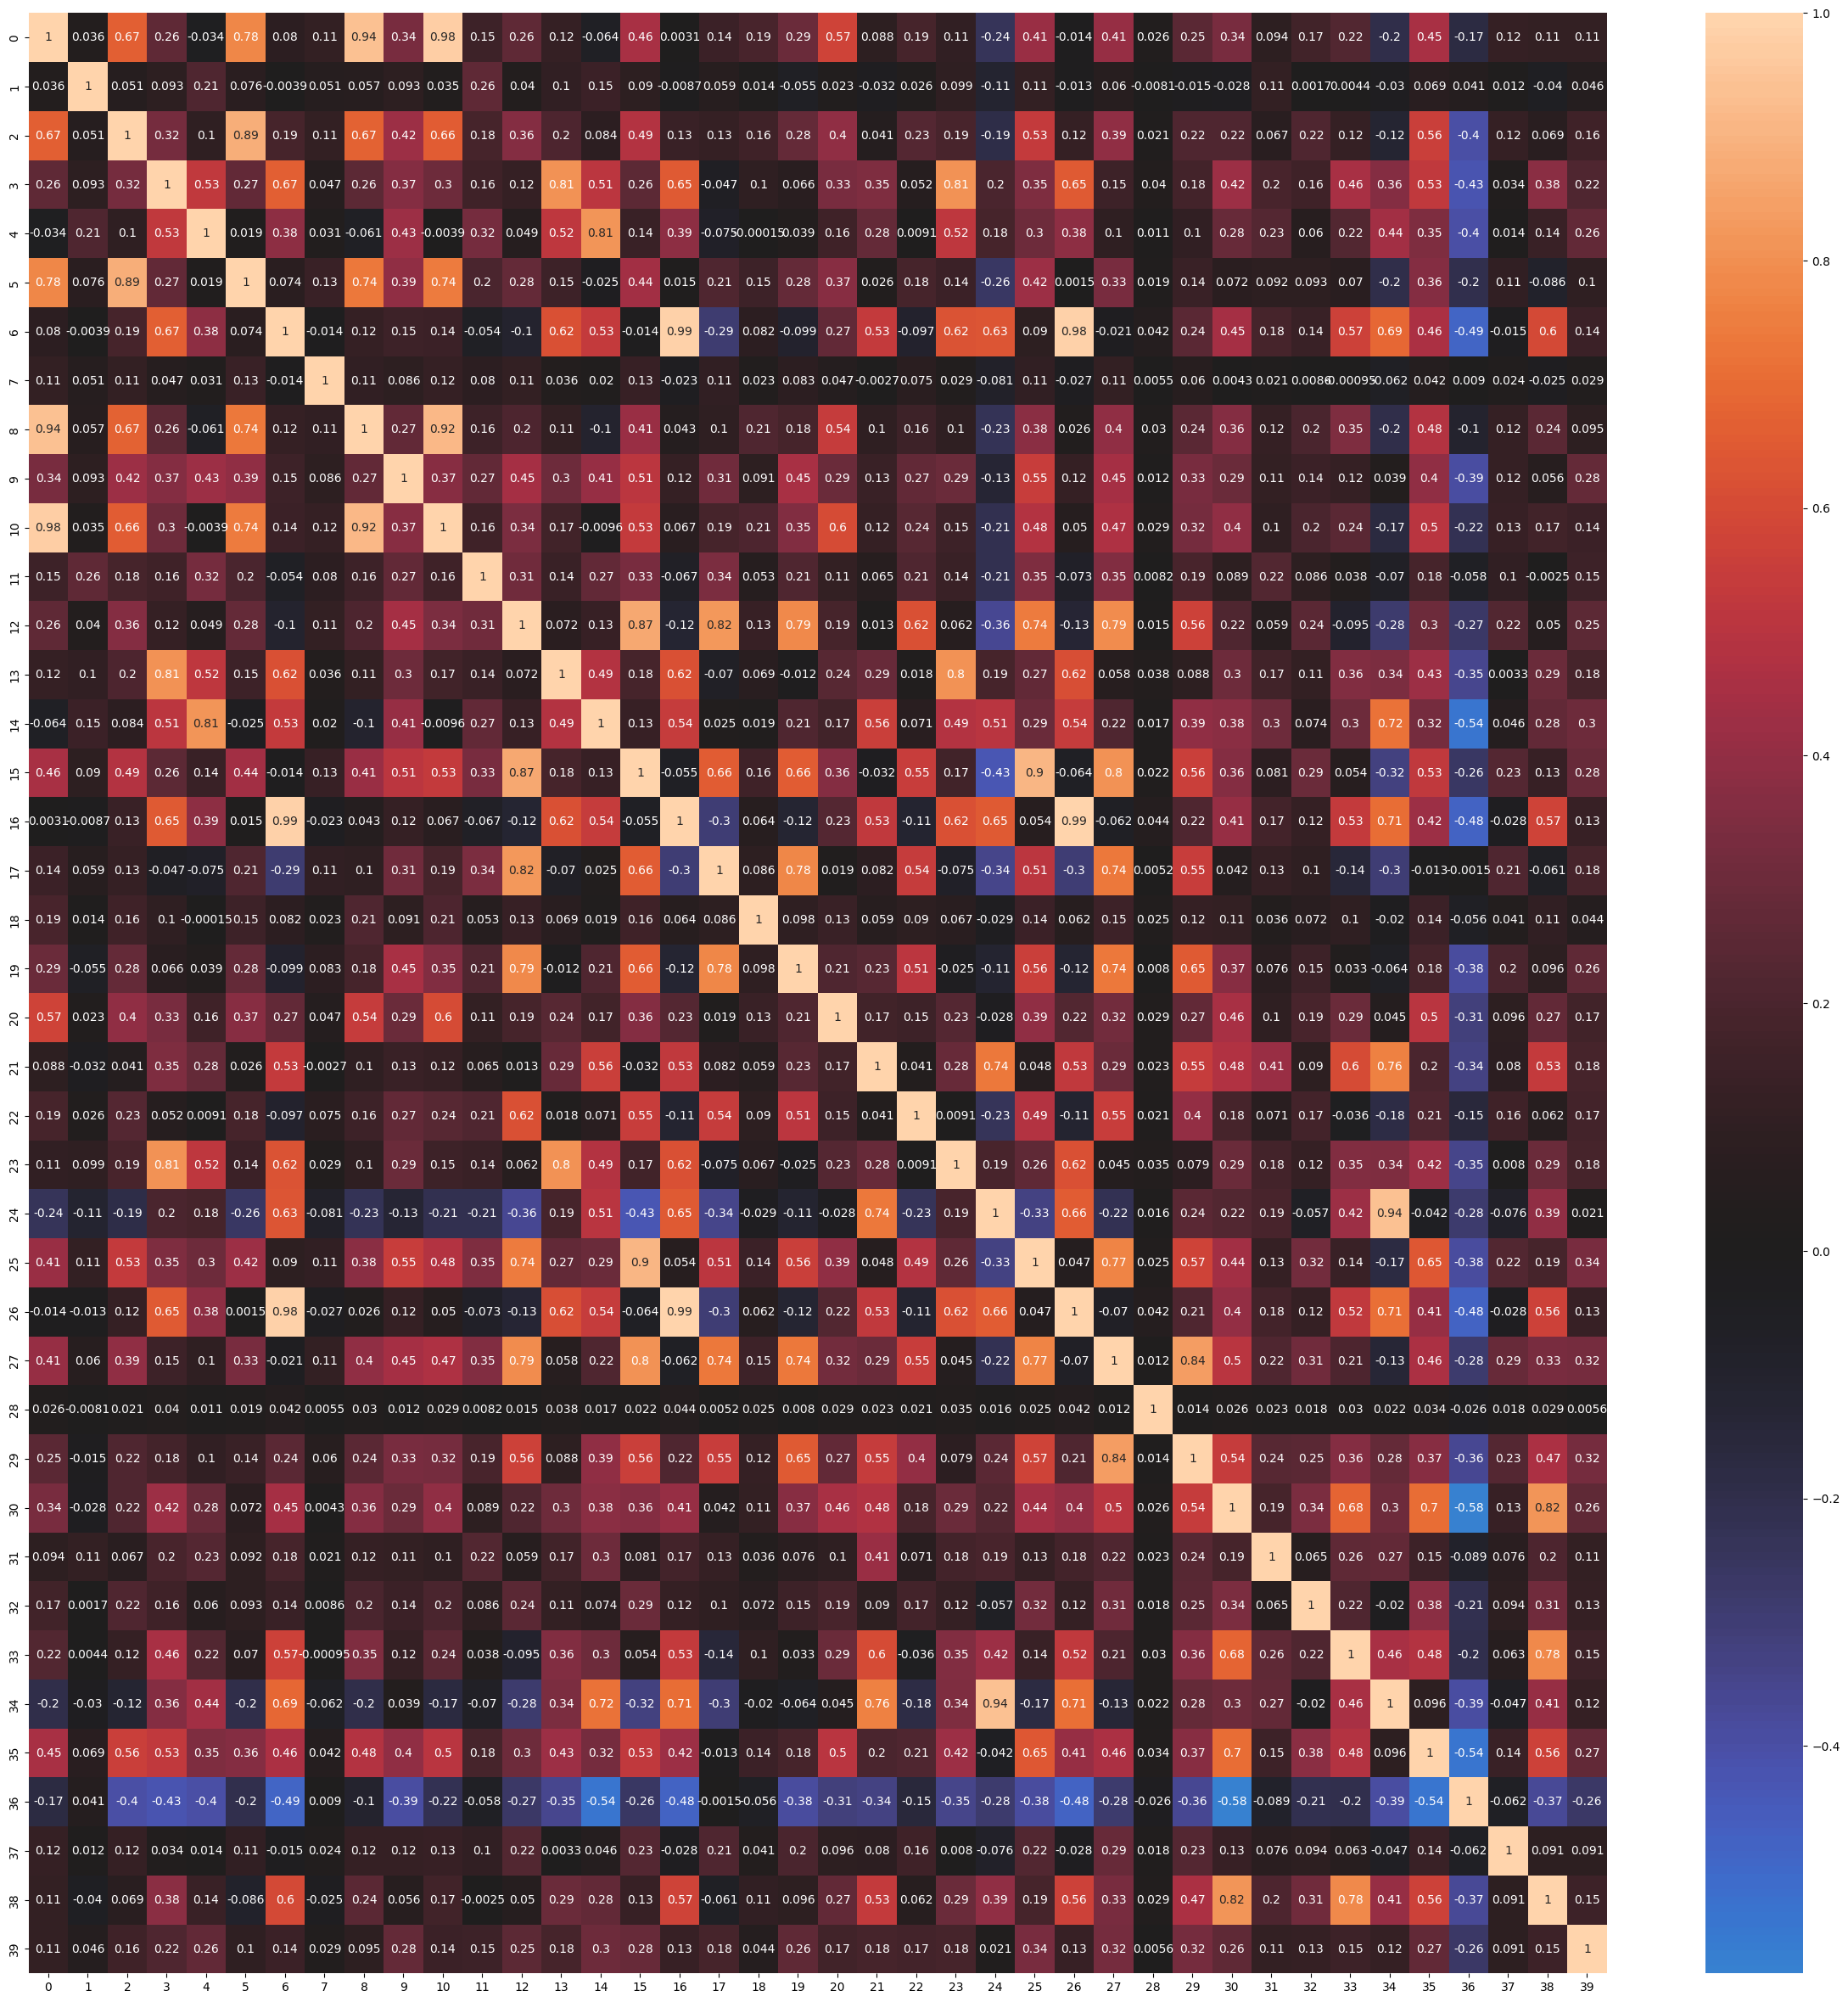

In [252]:
fig,ax=plt.subplots(figsize=(30,30))
sns.heatmap(X.corr(),ax=ax,annot=True,center=0);

Удалим все признаки, показатель корреляции у которой выше 80%

In [253]:
X_not_corr=X.drop([0,5,16,34,26,10,15,14,13,23,17],axis=1)
X_not_corr.shape

(32158, 29)

In [537]:
X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X_not_corr,y,random_state=42,stratify=y,test_size=0.2)

In [538]:
basemodel_1=LogisticRegression(random_state=42,max_iter=1000,n_jobs=4,class_weight='balanced')
basemodel_1.fit(X_train_1,y_train_1)

/home/roman/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=4,
                   random_state=42)

In [539]:
predict_train_1 = basemodel_1.predict(X_train_1)
predict_test_1 = basemodel_1.predict(X_test_1)

print(metrics.classification_report(y_train_1,predict_train_1))
print(metrics.classification_report(y_test_1,predict_test_1))

              precision    recall  f1-score   support

           0       0.85      0.49      0.62     14327
           1       0.45      0.80      0.58      1432
           2       0.59      0.83      0.69      1429
           3       0.55      0.91      0.68      1435
           4       0.48      0.84      0.61      1390
           5       0.59      0.79      0.67      1424
           6       0.56      0.82      0.66      1433
           7       0.50      0.85      0.63      1427
           8       0.73      0.81      0.76      1429

    accuracy                           0.64     25726
   macro avg       0.59      0.79      0.66     25726
weighted avg       0.72      0.64      0.64     25726

              precision    recall  f1-score   support

           0       0.84      0.49      0.62      3582
           1       0.44      0.81      0.57       358
           2       0.58      0.83      0.68       358
           3       0.54      0.91      0.68       359
           4       0.50 

Модель не стала сильно отличаться от базовой, но все же стоило удалить признаки с высокой корреляцией.

In [258]:
model_RT_1=RandomForestClassifier(max_depth=9,
                                  min_samples_leaf=5,
                                  n_estimators=800,
                                  random_state=42,
                                  class_weight='balanced',criterion='entropy')
model_RT_1.fit(X_train_1,y_train_1)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_leaf=5, n_estimators=800,
                       random_state=42)

In [259]:
predict_train_RT_1 = model_RT_1.predict(X_train_1)
predict_test_RT_1 = model_RT_1.predict(X_test_1)

print(metrics.classification_report(y_train_1,predict_train_RT_1))
print(metrics.classification_report(y_test_1,predict_test_RT_1))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     14327
           1       0.68      0.97      0.80      1432
           2       0.80      0.96      0.87      1429
           3       0.82      0.94      0.87      1435
           4       0.80      0.98      0.88      1390
           5       0.82      0.92      0.86      1424
           6       0.79      0.93      0.85      1433
           7       0.79      0.93      0.85      1427
           8       0.85      0.90      0.88      1429

    accuracy                           0.86     25726
   macro avg       0.81      0.92      0.86     25726
weighted avg       0.88      0.86      0.86     25726

              precision    recall  f1-score   support

           0       0.91      0.79      0.85      3582
           1       0.67      0.96      0.79       358
           2       0.81      0.92      0.86       358
           3       0.77      0.89      0.83       359
           4       0.79 

RobustScaler в вычислении использует перцентили, и поэтому не зависит даже от большого количества выбросов. Данные размечены более менее нормально.

In [260]:
from sklearn import preprocessing
sclr = preprocessing.RobustScaler()

cols=X_not_corr.columns
sclr.fit(X_not_corr)
X_nc_scaler=sclr.transform(X_not_corr)
X_nc_scaler = pd.DataFrame(X_nc_scaler, columns=cols)
X_nc_scaler

,1,2,3,4,6,7,8,9,11,12,...,29,30,31,32,33,35,36,37,38,39
0,0.000,0.471092,2.235294,1.090909,1.84,1.2,0.249361,0.6,0.2,0.409910,...,0.500000,0.849807,0.333333,-0.166667,0.308511,1.0,-0.266055,2.0,1.032653,1.000000
1,-0.375,0.451820,2.352941,1.000000,1.80,2.2,0.239130,-2.2,0.1,0.387387,...,0.508475,0.848400,0.000000,1.000000,0.319149,0.8,-0.284404,0.4,1.081633,0.666667
2,0.875,0.458244,2.000000,0.909091,1.76,0.8,0.241688,0.6,0.1,0.441441,...,0.512712,0.851214,0.777778,0.000000,0.308511,1.2,-0.298165,0.6,1.069388,1.333333
3,0.000,0.449679,1.941176,0.909091,1.80,0.0,0.244246,0.4,0.2,0.405405,...,0.516949,0.848400,-0.222222,-0.166667,0.265957,1.0,-0.311927,-0.4,1.065306,3.666667
4,0.750,0.443255,1.470588,0.727273,1.70,-0.4,0.234015,0.2,-0.1,0.432432,...,0.508475,0.842772,0.333333,-0.833333,0.265957,1.0,-0.311927,1.2,1.057143,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32153,0.875,1.276231,0.588235,0.363636,-0.20,-0.2,1.019182,3.4,-0.4,1.265766,...,0.025424,0.520577,0.111111,0.833333,0.489362,0.4,-0.211009,-0.2,-0.314286,1.333333
32154,-0.750,1.278373,0.529412,0.272727,-0.22,0.8,1.024297,1.6,0.6,1.202703,...,0.059322,0.541681,0.222222,0.166667,0.680851,0.2,-0.206422,1.2,-0.314286,1.333333
32155,0.000,1.289079,0.411765,0.727273,-0.30,-1.0,1.019182,1.4,0.2,1.202703,...,0.093220,0.545902,-0.444444,0.000000,0.670213,0.6,-0.206422,-2.0,-0.306122,1.333333
32156,-0.875,1.286938,0.588235,0.545455,-0.26,0.4,1.016624,1.4,-1.1,1.220721,...,0.114407,0.534647,0.666667,2.666667,0.712766,0.4,-0.201835,0.6,-0.302041,-6.333333


In [261]:
X_train_S,X_test_S,y_train_S,y_test_S=train_test_split(X_nc_scaler,y,random_state=42,stratify=y,test_size=0.2)

In [262]:
model_scaler_RT=RandomForestClassifier(max_depth=11,
                                       min_samples_leaf=3,
                                       random_state=42,
                                       n_estimators=800,
                                       class_weight='balanced',
                                       criterion='entropy')
model_scaler_RT.fit(X_train_S,y_train_S)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, min_samples_leaf=3, n_estimators=800,
                       random_state=42)

In [263]:
predict_train_scaler_RT = model_scaler_RT.predict(X_train_S)
predict_test_scaler_RT = model_scaler_RT.predict(X_test_S)

print(metrics.classification_report(y_train_S,predict_train_scaler_RT))
print(metrics.classification_report(y_test_S,predict_test_scaler_RT))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     14327
           1       0.80      0.99      0.89      1432
           2       0.86      1.00      0.92      1429
           3       0.88      1.00      0.93      1435
           4       0.88      1.00      0.93      1390
           5       0.84      1.00      0.91      1424
           6       0.84      0.99      0.91      1433
           7       0.84      1.00      0.91      1427
           8       0.85      1.00      0.92      1429

    accuracy                           0.92     25726
   macro avg       0.86      0.98      0.92     25726
weighted avg       0.93      0.92      0.92     25726

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      3582
           1       0.78      0.98      0.87       358
           2       0.85      0.98      0.91       358
           3       0.83      0.96      0.89       359
           4       0.85 

Так же удаляем столбцы с высокой корреляцией из тестовых данных

In [264]:
data_nc=data.drop([0,5,16,34,26,10,15,14,13,23,17,'class'],axis=1)
data_nc

,1,2,3,4,6,7,8,9,11,12,...,29,30,31,32,33,35,36,37,38,39
0,10.0,1450.0,64.0,34.0,145.0,12.0,1068.0,14.0,20.0,652.0,...,1192.0,1877.0,73.0,13.0,1169.0,29.0,1677.0,36.0,718.0,26.0
1,7.0,1441.0,66.0,33.0,143.0,17.0,1064.0,0.0,19.0,647.0,...,1194.0,1876.0,70.0,20.0,1170.0,28.0,1673.0,28.0,730.0,25.0
2,17.0,1444.0,60.0,32.0,141.0,10.0,1065.0,14.0,19.0,659.0,...,1195.0,1878.0,77.0,14.0,1169.0,30.0,1670.0,29.0,727.0,27.0
3,10.0,1440.0,59.0,32.0,143.0,6.0,1066.0,13.0,20.0,651.0,...,1196.0,1876.0,68.0,13.0,1165.0,29.0,1667.0,24.0,726.0,34.0
4,16.0,1437.0,51.0,30.0,138.0,4.0,1062.0,12.0,17.0,657.0,...,1194.0,1872.0,73.0,9.0,1165.0,29.0,1667.0,32.0,724.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,17.0,1826.0,36.0,26.0,43.0,5.0,1369.0,28.0,14.0,842.0,...,1080.0,1643.0,71.0,19.0,1186.0,26.0,1689.0,25.0,388.0,27.0
96,4.0,1827.0,35.0,25.0,42.0,10.0,1371.0,19.0,24.0,828.0,...,1088.0,1658.0,72.0,15.0,1204.0,25.0,1690.0,32.0,388.0,27.0
97,10.0,1832.0,33.0,30.0,38.0,1.0,1369.0,18.0,20.0,828.0,...,1096.0,1661.0,66.0,14.0,1203.0,27.0,1690.0,16.0,390.0,27.0
98,3.0,1831.0,36.0,28.0,40.0,8.0,1368.0,18.0,7.0,832.0,...,1101.0,1653.0,76.0,30.0,1207.0,26.0,1691.0,29.0,391.0,4.0


Производим так же к нормализации наши тестовые данные

In [265]:
data_nc_col=data_nc.columns
data_nc_scaler=sclr.transform(data_nc)

data_nc_scaler=pd.DataFrame(data_nc_scaler,columns=data_nc_col)
data_nc_scaler

,1,2,3,4,6,7,8,9,11,12,...,29,30,31,32,33,35,36,37,38,39
0,0.000,0.471092,2.235294,1.090909,1.84,1.2,0.249361,0.6,0.2,0.409910,...,0.500000,0.849807,0.333333,-0.166667,0.308511,1.0,-0.266055,2.0,1.032653,1.000000
1,-0.375,0.451820,2.352941,1.000000,1.80,2.2,0.239130,-2.2,0.1,0.387387,...,0.508475,0.848400,0.000000,1.000000,0.319149,0.8,-0.284404,0.4,1.081633,0.666667
2,0.875,0.458244,2.000000,0.909091,1.76,0.8,0.241688,0.6,0.1,0.441441,...,0.512712,0.851214,0.777778,0.000000,0.308511,1.2,-0.298165,0.6,1.069388,1.333333
3,0.000,0.449679,1.941176,0.909091,1.80,0.0,0.244246,0.4,0.2,0.405405,...,0.516949,0.848400,-0.222222,-0.166667,0.265957,1.0,-0.311927,-0.4,1.065306,3.666667
4,0.750,0.443255,1.470588,0.727273,1.70,-0.4,0.234015,0.2,-0.1,0.432432,...,0.508475,0.842772,0.333333,-0.833333,0.265957,1.0,-0.311927,1.2,1.057143,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,0.875,1.276231,0.588235,0.363636,-0.20,-0.2,1.019182,3.4,-0.4,1.265766,...,0.025424,0.520577,0.111111,0.833333,0.489362,0.4,-0.211009,-0.2,-0.314286,1.333333
32296,-0.750,1.278373,0.529412,0.272727,-0.22,0.8,1.024297,1.6,0.6,1.202703,...,0.059322,0.541681,0.222222,0.166667,0.680851,0.2,-0.206422,1.2,-0.314286,1.333333
32297,0.000,1.289079,0.411765,0.727273,-0.30,-1.0,1.019182,1.4,0.2,1.202703,...,0.093220,0.545902,-0.444444,0.000000,0.670213,0.6,-0.206422,-2.0,-0.306122,1.333333
32298,-0.875,1.286938,0.588235,0.545455,-0.26,0.4,1.016624,1.4,-1.1,1.220721,...,0.114407,0.534647,0.666667,2.666667,0.712766,0.4,-0.201835,0.6,-0.302041,-6.333333


Проверим нашу модель на размеченных данных

In [266]:
y_train_svod_1['class_predict_3']=model_scaler_RT.predict(data_nc_scaler)
y_train_svod_1

,sample-timestep,class,sample_id,timestep,class_predict_1,class_predict_2,class_predict_3
0,0-0,0,0,0,5,0,0
1,0-1,0,0,1,5,0,0
2,0-2,0,0,2,5,0,0
3,0-3,0,0,3,5,0,0
4,0-4,0,0,4,5,0,0
...,...,...,...,...,...,...,...
32295,322-95,4,322,95,4,4,4
32296,322-96,4,322,96,4,4,4
32297,322-97,4,322,97,4,4,4
32298,322-98,4,322,98,4,4,4


In [267]:
mask_predict_3 = y_train_svod_1.pivot(index='sample_id', columns='timestep', values='class_predict_3')
mask_predict_3_index = mask_predict_3.index
mask_predict_3 = mask_predict_3.sort_index() # на всякий случай
mask_predict_3 = mask_predict_3.values

print(mask_predict_3.shape)
pd.DataFrame(mask_predict_3)

(323, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,0,0,0,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8
319,8,8,8,8,8,8,8,8,8,8,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
321,7,7,7,7,7,7,7,7,7,7,...,0,0,0,0,0,0,0,0,4,4


In [268]:
pd.DataFrame(y_train_svod)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,0,0,0,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8
319,8,8,8,8,8,8,8,8,8,8,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
321,7,7,7,7,7,7,7,7,7,7,...,0,0,0,0,0,0,0,0,0,0


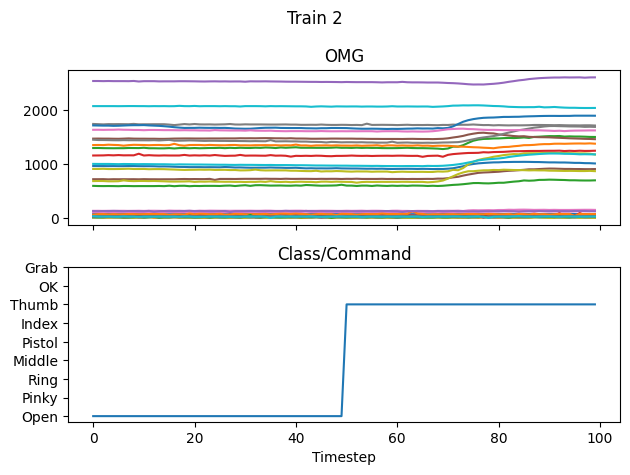

In [542]:
i = 2

fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train_svod[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

Так же загрузив  начале размеченные данные и будем смотреть, что показывает наша модель.

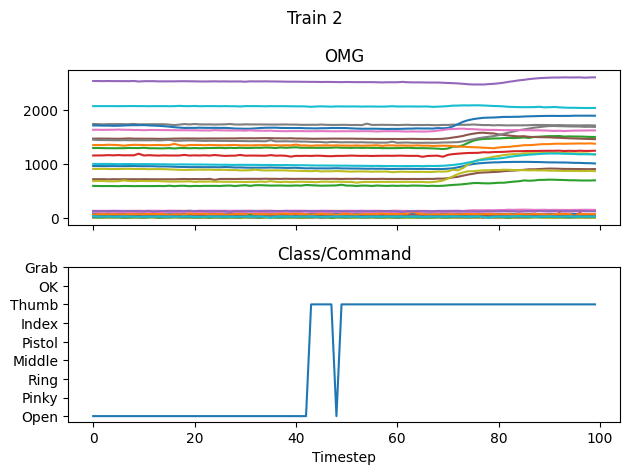

In [543]:
i=2
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(mask_predict_3[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

Попробуем предсказать наши тестовые данные без разметки.

ТЕСТ

Приведем данные все к типу, который нам потребуется для визуализации.

In [285]:
data_y_test=pd.DataFrame(X_test[0].T)
for num in range(1,len(X_test)):
    data_y_test=pd.concat([data_y_test,pd.DataFrame(X_test[num].T)],axis=0) 
data_y_test     

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1681.0,4.0,1834.0,33.0,26.0,2254.0,43.0,0.0,1376.0,27.0,...,1635.0,82.0,16.0,1204.0,108.0,25.0,1685.0,27.0,386.0,25.0
1,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,1643.0,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0
2,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,1658.0,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0
3,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,1661.0,66.0,14.0,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0
4,1670.0,3.0,1831.0,36.0,28.0,2249.0,40.0,8.0,1368.0,18.0,...,1653.0,76.0,30.0,1207.0,107.0,26.0,1691.0,29.0,391.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1887.0,16.0,1856.0,43.0,53.0,2308.0,61.0,16.0,1444.0,24.0,...,1631.0,60.0,11.0,1166.0,120.0,28.0,1675.0,36.0,316.0,29.0
96,1884.0,17.0,1850.0,27.0,45.0,2304.0,61.0,7.0,1441.0,25.0,...,1641.0,69.0,3.0,1166.0,122.0,28.0,1668.0,29.0,315.0,29.0
97,1882.0,13.0,1843.0,37.0,51.0,2299.0,60.0,1.0,1437.0,25.0,...,1659.0,75.0,18.0,1167.0,119.0,28.0,1676.0,26.0,313.0,30.0
98,1886.0,14.0,1835.0,37.0,49.0,2296.0,61.0,5.0,1436.0,25.0,...,1686.0,76.0,9.0,1157.0,122.0,27.0,1673.0,27.0,318.0,32.0


In [286]:
X_not_corr_test=data_y_test.drop([0,5,16,34,26,10,15,14,13,23,17],axis=1)


In [287]:
col=X_not_corr_test.columns
X_nc_test_scaler=sclr.transform(X_not_corr_test)
X_nc_test_scaler = pd.DataFrame(X_nc_test_scaler, columns=col)


In [502]:
y_test['class']= model_scaler_RT.predict(X_nc_test_scaler)



In [503]:

y_test[['sample_id', 'timestep']] = y_test['sample-timestep'].str.split('-', n=1, expand=True).astype(int)
y_test


,sample-timestep,class,sample_id,timestep
0,323-0,4,323,0
1,323-1,4,323,1
2,323-2,4,323,2
3,323-3,4,323,3
4,323-4,4,323,4
...,...,...,...,...
5395,376-95,4,376,95
5396,376-96,4,376,96
5397,376-97,4,376,97
5398,376-98,4,376,98


In [504]:
y_predict_f = y_test.pivot(index='sample_id', columns='timestep', values='class')
y_predict_f_index = y_predict_f.index
y_predict_f = y_predict_f.sort_index() # на всякий случай
y_predict_f = y_predict_f.values

y_predict_f


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]])

3


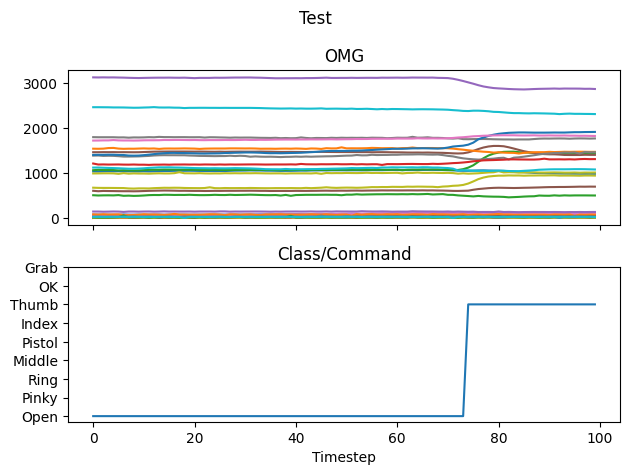

In [505]:
i=3

fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_predict_f[i])

axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test')

plt.tight_layout()
print(i)

Видим, что по графику изменения идут дальше отметки 50, но ранее на размеченных данных заметил, что уникальных значений в одном наблюдении всего не более 2х и само изменение в действии находится на отметке 50. Сделаем преобразование, что бы и в моих данных было так же.

In [ ]:
for i in range(pd.DataFrame(y_predict_f).shape[0]):
   
    pd.DataFrame(y_predict_f).T[i].loc[:49]=pd.DataFrame(y_predict_f).loc[i,0]
    pd.DataFrame(y_predict_f).T[i].loc[50:]=pd.DataFrame(y_predict_f).loc[i,99]

In [531]:
y_test['class']=pd.DataFrame(y_predict_f).stack().reset_index()[0]

In [534]:
y_test.drop(['sample_id','timestep'],axis=1,inplace=True)
y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4
